In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd

In [3]:
def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])

        return res

    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

In [4]:
def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()

In [5]:
# 定义工具函数
pctrank = lambda x: x.rank(pct=True).iloc[-1]

# 从csv文件获取指数价格数据
index_data = pd.read_csv('./指数估值历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

# 设置回测参数
index_id = 'hs300' # 选择指数
index_id_pe = index_id + '_pe' # 选择市盈率
pe_rank_window = 242*5 # 计算PE分位数滑动窗口长度（按交易日数目）

# 输出测试
index_data

,csi500,hs300,csi500_pe,hs300_pe
2005-01-04,986.9270,982.7940,31.651584,15.706840
2005-01-05,1003.6330,992.5640,32.194286,15.768370
2005-01-06,994.5950,983.1740,31.906585,15.585092
2005-01-07,997.6060,983.9580,31.981522,15.632757
2005-01-10,1006.3370,993.8790,32.262616,15.729727
...,...,...,...,...
2021-08-12,7095.2024,4973.3509,22.566053,13.937787
2021-08-13,7088.8876,4945.9829,22.500404,13.864159
2021-08-16,7052.4876,4941.0676,22.377592,13.829034
2021-08-17,6894.4042,4837.4034,21.878157,13.574710


In [6]:
# 回测过程
df = index_data.loc[:,[index_id]]
df['pe'] = index_data[index_id_pe]
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1+df['index_ret']).cumprod().fillna(1)
df['pe_rank'] = df['pe'].rolling(window=pe_rank_window).apply(pctrank)
df['pos'] = np.nan

for t in range(pe_rank_window,len(df.index)):
    # 策略：高于0.8则空仓，回到0.5则重新满仓，否则保持昨仓
    prev_pe_rank = df.loc[df.index[t-1],'pe_rank']
    prev_pos = df.loc[df.index[t-1], 'pos']
    prev_pos = 1 if np.isnan(prev_pos) else prev_pos
    df.loc[df.index[t],'pos'] = 0 if prev_pe_rank>0.8 else (1 if prev_pe_rank<0.5 else prev_pos)
    
df

,hs300,pe,index_ret,index,pe_rank,pos
2005-01-04,982.7940,15.706840,NaN,1.000000,NaN,NaN
2005-01-05,992.5640,15.768370,0.009941,1.009941,NaN,NaN
2005-01-06,983.1740,15.585092,-0.009460,1.000387,NaN,NaN
2005-01-07,983.9580,15.632757,0.000797,1.001184,NaN,NaN
2005-01-10,993.8790,15.729727,0.010083,1.011279,NaN,NaN
...,...,...,...,...,...,...
2021-08-12,4973.3509,13.937787,-0.008372,5.060420,0.659504,0.0
2021-08-13,4945.9829,13.864159,-0.005503,5.032573,0.652066,0.0
2021-08-16,4941.0676,13.829034,-0.000994,5.027572,0.647107,0.0
2021-08-17,4837.4034,13.574710,-0.020980,4.922093,0.595868,0.0


In [7]:
# 计算回测业绩
backtest_start_date = index_data.index[pe_rank_window]

df['stgy_ret'] = df['pos'] * df['index_ret']
df['stgy'] = (1+df['stgy_ret']).cumprod() * df.loc[backtest_start_date,'index']

df

,hs300,pe,index_ret,index,pe_rank,pos,stgy_ret,stgy
2005-01-04,982.7940,15.706840,NaN,1.000000,NaN,NaN,NaN,NaN
2005-01-05,992.5640,15.768370,0.009941,1.009941,NaN,NaN,NaN,NaN
2005-01-06,983.1740,15.585092,-0.009460,1.000387,NaN,NaN,NaN,NaN
2005-01-07,983.9580,15.632757,0.000797,1.001184,NaN,NaN,NaN,NaN
2005-01-10,993.8790,15.729727,0.010083,1.011279,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-08-12,4973.3509,13.937787,-0.008372,5.060420,0.659504,0.0,-0.0,5.919843
2021-08-13,4945.9829,13.864159,-0.005503,5.032573,0.652066,0.0,-0.0,5.919843
2021-08-16,4941.0676,13.829034,-0.000994,5.027572,0.647107,0.0,-0.0,5.919843
2021-08-17,4837.4034,13.574710,-0.020980,4.922093,0.595868,0.0,-0.0,5.919843


<AxesSubplot:title={'center':'pe'}>

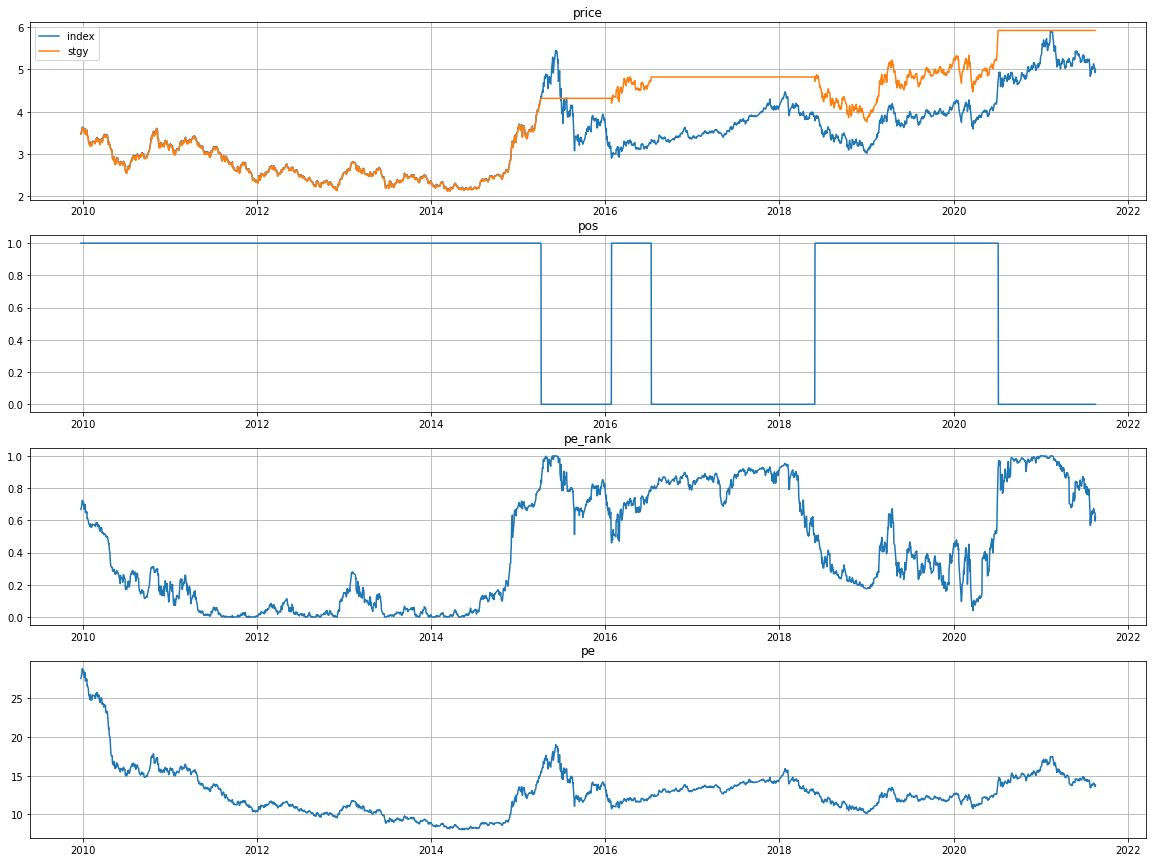

In [8]:
# 绘制回测结果走势图
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(4,1,1)
df.loc[backtest_start_date:,['index', 'stgy']].plot(ax=ax1, grid=True, title='price')

ax2 = fig.add_subplot(4,1,2)
df.loc[backtest_start_date:,'pos'].plot(ax=ax2, grid=True, title='pos')

ax3 = fig.add_subplot(4,1,3)
df.loc[backtest_start_date:,'pe_rank'].plot(ax=ax3, grid=True, title='pe_rank')

ax4 = fig.add_subplot(4,1,4)
df.loc[backtest_start_date:,'pe'].plot(ax=ax4, grid=True, title='pe')

In [9]:
# 计算回测业绩指标表
res = cal_period_perf_indicator(df.loc[backtest_start_date:,['index','stgy']])
print(res)

         AnnRet    AnnVol        SR     MaxDD   Calmar
index  0.030978  0.225119  0.137608 -0.466961  0.06634
stgy   0.046689  0.177561  0.262946 -0.416345  0.11214
